In [1]:
import tensorflow as tf

from tensorflow.keras.applications import VGG19

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.utils.class_weight import compute_class_weight



# Define the directories for training and validation

train_data_dir = '/content/drive/MyDrive/SplitImages/train'

validation_data_dir = '/content/drive/MyDrive/SplitImages/validation'



# Define early stopping and learning rate reduction callbacks

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)



# Define batch sizes and other parameters

batch_size_train = 16  # Smaller batch size for histological images

batch_size_val = 16

epochs = 100



# Data generators with augmentation and preprocessing suitable for histological images

train_datagen = ImageDataGenerator(

    rescale=1.0 / 255,

    rotation_range=15,

    width_shift_range=0.1,

    height_shift_range=0.1,

    shear_range=0.1,

    zoom_range=0.1,

    horizontal_flip=True,

    preprocessing_function=tf.keras.applications.vgg19.preprocess_input  # VGG19-specific preprocessing

)



validation_datagen = ImageDataGenerator(

    rescale=1.0 / 255,

    preprocessing_function=tf.keras.applications.vgg19.preprocess_input

)



train_generator = train_datagen.flow_from_directory(

    train_data_dir,

    target_size=(375, 375),  # Adjusted target size suitable for VGG19

    batch_size=batch_size_train,

    classes=['Non-Tumor', 'Non-Viable-Tumor'],

    class_mode='binary'

)



validation_generator = validation_datagen.flow_from_directory(

    validation_data_dir,

    target_size=(375, 375),

    batch_size=batch_size_val,

    classes=['Non-Tumor', 'Non-Viable-Tumor'],

    class_mode='binary'

)



# Load the VGG19 model with pre-trained weights and discard the top (fully connected) layers

base_model = VGG19(include_top=False, weights='imagenet', input_shape=(375, 375, 3))



# Freeze most of the pre-trained layers

for layer in base_model.layers[:-4]:

    layer.trainable = False



x = Flatten()(base_model.output)

x = Dense(256, activation='relu')(x)

x = BatchNormalization()(x)

x = Dropout(0.5)(x)

output_binary = Dense(1, activation='sigmoid')(x)



model_binary = Model(inputs=base_model.input, outputs=output_binary)



# Compile the model

optimizer = Adam(learning_rate=0.0001)

model_binary.compile(

    optimizer=optimizer,

    loss='binary_crossentropy',

    metrics=['accuracy']

)



# Compute class weights

class_weights = compute_class_weight('balanced', classes=[0, 1], y=train_generator.classes)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}



# Train the model

history = model_binary.fit(

    train_generator,

    steps_per_epoch=train_generator.samples // batch_size_train,

    epochs=epochs,

    validation_data=validation_generator,

    validation_steps=validation_generator.samples // batch_size_val,

    callbacks=[early_stopping, reduce_lr],

    class_weight=class_weight_dict

)



# Print the classes used for binary classification

print("Classes used for binary classification:", train_generator.class_indices)

Found 596 images belonging to 2 classes.
Found 204 images belonging to 2 classes.
80134624/80134624 [==============================] - 0s 0us/step
Epoch 1/100
37/37 [==============================] - 128s 3s/step - loss: 0.3689 - accuracy: 0.8750 - val_loss: 0.5555 - val_accuracy: 0.8802 - lr: 1.0000e-04
Epoch 2/100
37/37 [==============================] - 27s 732ms/step - loss: 0.2267 - accuracy: 0.9138 - val_loss: 0.2555 - val_accuracy: 0.9062 - lr: 1.0000e-04
Epoch 3/100
37/37 [==============================] - 26s 715ms/step - loss: 0.2007 - accuracy: 0.9190 - val_loss: 0.6643 - val_accuracy: 0.8958 - lr: 1.0000e-04
Epoch 4/100
37/37 [==============================] - 29s 776ms/step - loss: 0.1701 - accuracy: 0.9276 - val_loss: 0.4882 - val_accuracy: 0.8958 - lr: 1.0000e-04
Epoch 5/100
37/37 [==============================] - 27s 728ms/step - loss: 0.1859 - accuracy: 0.9224 - val_loss: 0.4954 - val_accuracy: 0.8802 - lr: 1.0000e-04
Epoch 6/100
37/37 [==============================]

In [2]:
test_data_dir = '/content/drive/MyDrive/SplitImages/test'



test_datagen = ImageDataGenerator(

    rescale=1.0 / 255,

    preprocessing_function=tf.keras.applications.vgg19.preprocess_input

)



test_generator = test_datagen.flow_from_directory(

    test_data_dir,

    target_size=(375, 375),

    batch_size=batch_size_val,  # Use batch_size_val for testing

    classes=['Non-Tumor', 'Non-Viable-Tumor'],

    class_mode='binary'

)



# Evaluate the model on the test data

test_loss, test_accuracy = model_binary.evaluate(test_generator)



print("Test Loss:", test_loss)

print("Test Accuracy:", test_accuracy)

Found 52 images belonging to 2 classes.
4/4 [==============================] - 8s 2s/step - loss: 0.1197 - accuracy: 0.9615
Test Loss: 0.11965452879667282
Test Accuracy: 0.9615384340286255


1/1 [==============================] - 0s 40ms/step


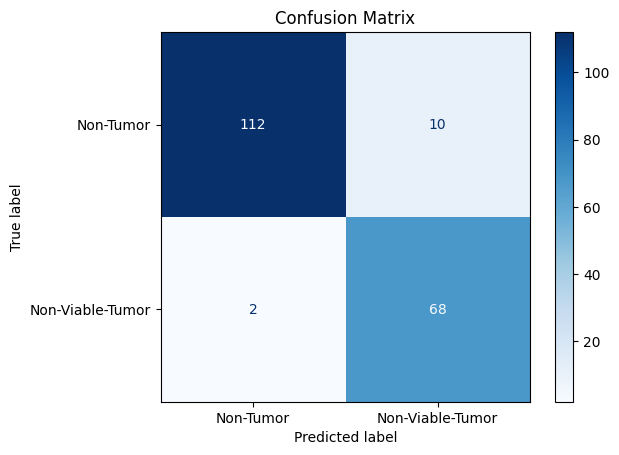

In [4]:
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt



# Predict classes for validation data

validation_steps = validation_generator.samples // batch_size_val

y_true = []

y_pred = []



for i in range(validation_steps):

    x_val, y_val = validation_generator.next()

    y_true.extend(y_val)

    y_pred.extend(model_binary.predict(x_val))



y_true = np.array(y_true)

y_pred = np.array(y_pred)

y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions



# Compute confusion matrix

cm = confusion_matrix(y_true, y_pred_binary)



# Display confusion matrix

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Tumor', 'Non-Viable-Tumor'])

disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")

plt.show()





Layer Index: 1, Layer Name: block1_conv1
Layer Index: 2, Layer Name: block1_conv2
Layer Index: 4, Layer Name: block2_conv1
Layer Index: 5, Layer Name: block2_conv2
Layer Index: 7, Layer Name: block3_conv1
Layer Index: 8, Layer Name: block3_conv2
Layer Index: 9, Layer Name: block3_conv3
Layer Index: 10, Layer Name: block3_conv4
Layer Index: 12, Layer Name: block4_conv1
Layer Index: 13, Layer Name: block4_conv2
Layer Index: 14, Layer Name: block4_conv3
Layer Index: 15, Layer Name: block4_conv4
Layer Index: 17, Layer Name: block5_conv1
Layer Index: 18, Layer Name: block5_conv2
Layer Index: 19, Layer Name: block5_conv3
Layer Index: 20, Layer Name: block5_conv4


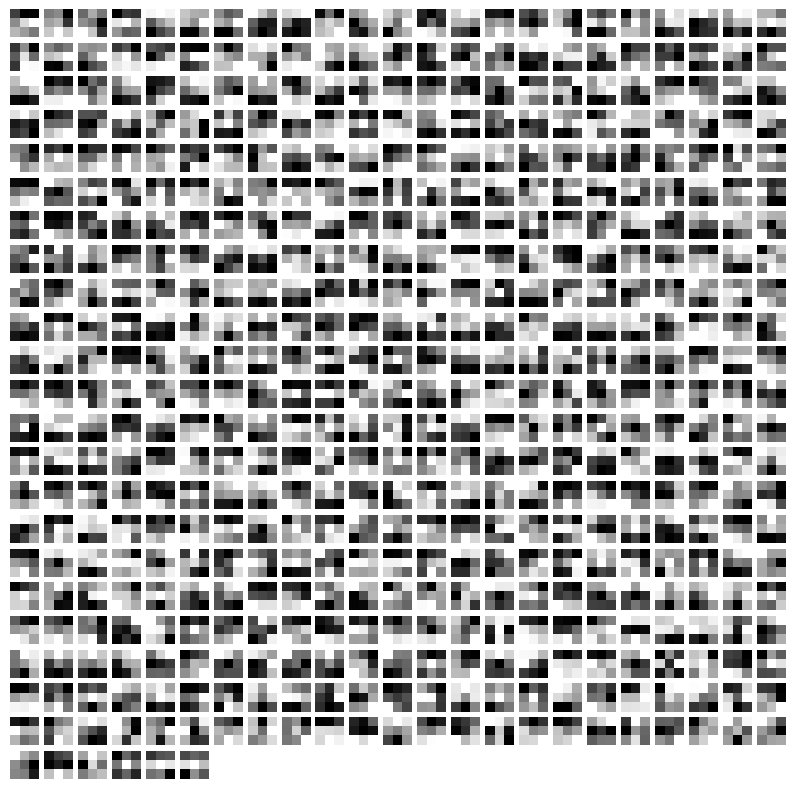

In [7]:
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import math  # Import the math module to handle rounding up

# Assuming you have defined and compiled your 'model_binary' somewhere above

model_layers = model_binary.layers

conv_layer_indices = []

for index, layer in enumerate(model_layers):
    if 'conv' in layer.name:
        print(f"Layer Index: {index}, Layer Name: {layer.name}")
        conv_layer_indices.append(index)

index_of_conv_layer = 20

conv_layer = model_binary.layers[index_of_conv_layer]

filters, biases = conv_layer.get_weights()

normalized_filters = (filters - filters.min()) / (filters.max() - filters.min())

number_of_filters = filters.shape[3]

sqrt_number_of_filters = int(math.ceil(math.sqrt(number_of_filters)))  # Round up to ensure enough subplots
subplot_rows = sqrt_number_of_filters
subplot_cols = sqrt_number_of_filters

plt.figure(figsize=(10, 10))

for i in range(number_of_filters):
    plt.subplot(subplot_rows, subplot_cols, i+1)
    plt.imshow(normalized_filters[:, :, 0, i], cmap='gray')
    plt.axis('off')

plt.show()


1/1 [==============================] - 0s 494ms/step


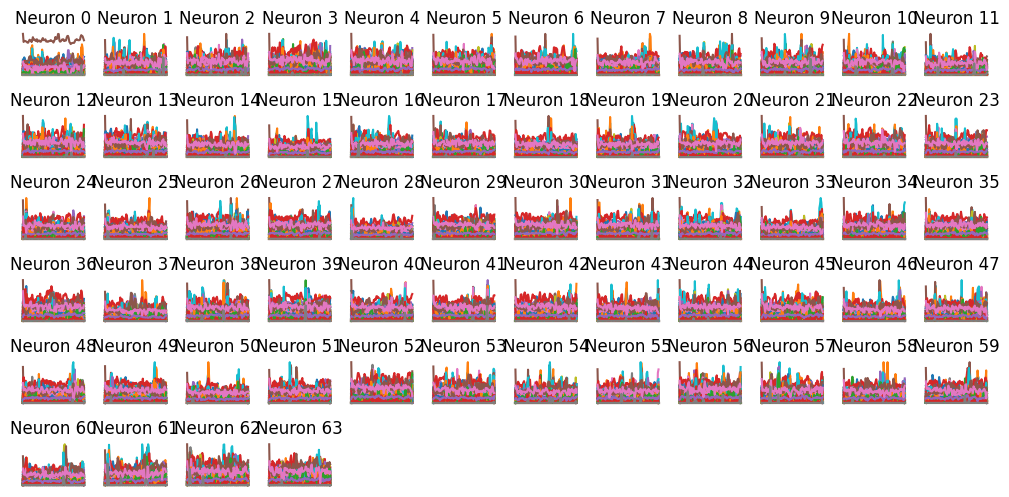

Class Names: ['Non-Tumor', 'Non-Viable-Tumor']


In [8]:
import numpy as np

import matplotlib.pyplot as plt

from tensorflow.keras.models import Model



# Load the best model weights

model_binary = model_binary  # Replace with the actual path



# Create a new model that extracts the activations of the first dense layer

activation_model = Model(inputs=model_binary.input, outputs=model_binary.layers[6].output)



# Get the class indices from the generator

class_indices = train_generator.class_indices

class_names = list(class_indices.keys())



# Choose a random image batch from the validation generator

sample_batch = next(iter(validation_generator))

sample_images = sample_batch[0]



# Choose a random image index from the batch

image_index = np.random.randint(0, batch_size_val)



# Get the activations of the first dense layer for the selected image

activations = activation_model.predict(sample_images[image_index : image_index + 1])



# Determine the number of neurons in the layer

num_neurons = activations.shape[-1]



# Calculate the number of rows and columns for subplots

sqrt_num_neurons = int(np.ceil(np.sqrt(num_neurons)))



# Limit the number of neurons to visualize to a reasonable value

max_neurons_to_visualize = 64

num_neurons_to_visualize = min(max_neurons_to_visualize, num_neurons)



# Visualize the activations for each neuron

plt.figure(figsize=(10, 10))

for neuron_index in range(num_neurons_to_visualize):

    plt.subplot(sqrt_num_neurons, sqrt_num_neurons, neuron_index + 1)

    plt.plot(activations[0, neuron_index])

    plt.axis('off')

    plt.title(f'Neuron {neuron_index}')

plt.tight_layout()

plt.show()



# Print the class names

print("Class Names:", class_names)

